<a href="https://colab.research.google.com/github/Rhythm1821/GAN-Project/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 Import dependencies

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [2]:
for gpu in gpus:
  print(gpu)

In [3]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [4]:
ds = tfds.load('fashion_mnist',split='train')

## 2 Visualize and build the dataset

In [5]:
dataiterator = ds.as_numpy_iterator()

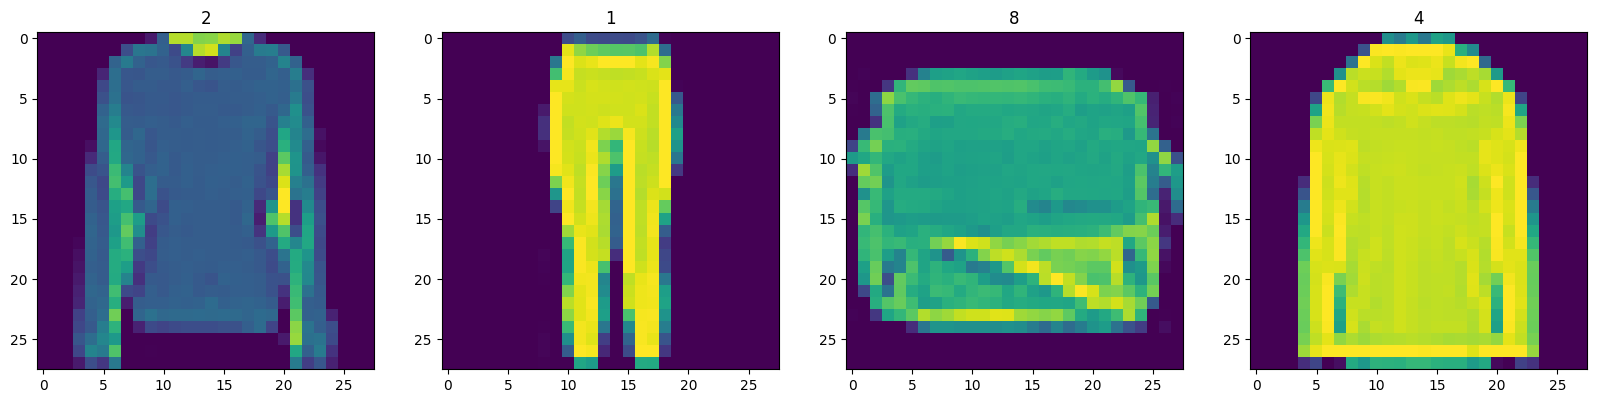

In [6]:
import numpy as np
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx in range(4):
  batch = dataiterator.next()
  ax[idx].imshow(np.squeeze(batch['image']))
  ax[idx].title.set_text(batch['label'])

In [7]:
def scale_image(data):
  img = data['image']
  return img / 255

#### Data pipeline for tensorflow
* map
* cache
* shuffle
* batch
* prefetch

In [8]:
# Reload the dataset
ds = tfds.load('fashion_mnist',split='train')
# Running the dataset throught the scale images preprocessing step
ds = ds.map(scale_image)
# Cache the dataset for that batch
ds = ds.cache()
# shuffle it up
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [9]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## 3 Build a neural network

### 3.1 Import modelling components

In [10]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Reshape,LeakyReLU,Dropout,UpSampling2D

### 3.2 Build a generator

In [11]:
# Build a generator
def build_generator():
  model = Sequential()

  # Takes in random values and reshapes it to 7*7*128
  # Beginnings of a generated image
  model.add(Dense(7*7*128,input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # Upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  # Upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  # Conv2D block 1
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  # Conv2D block 2
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  # Conv layer to get one channel
  model.add(Conv2D(1,4,padding='same',activation='sigmoid'))

  return model

In [12]:
generator = build_generator()

In [13]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [14]:
img = generator.predict(np.random.randn(4,128,1))
img.shape

1/1 [==============================] - 0s 364ms/step


(4, 28, 28, 1)

In [15]:
img.shape

(4, 28, 28, 1)

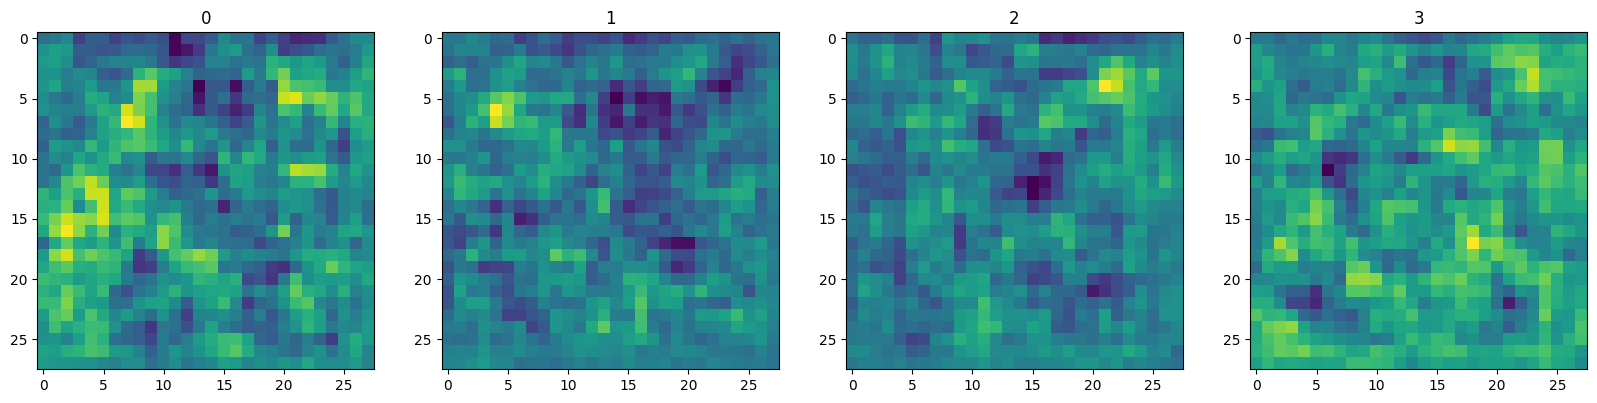

In [16]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(img):
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)

### 3.3 Build a discriminator

In [17]:
from keras.api._v2.keras import activations

def build_discriminator():
  model = Sequential()

  # Conv block 1
  model.add(Conv2D(32,5,input_shape=(28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Conv block 2
  model.add(Conv2D(64,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Conv block 3
  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Conv block 4
  model.add(Conv2D(256,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Flatten and then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))

  return model

In [18]:
discriminator = build_discriminator()

In [19]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [20]:
discriminator.predict(np.expand_dims(img,0))

1/1 [==============================] - 0s 110ms/step


array([[0.4963945]], dtype=float32)

## 4 Construct training loop

### 4.1 Setup losses and optimizers

In [21]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary Cross Entropy Loss will be the loss for both g & d
from tensorflow.keras.losses import BinaryCrossentropy

In [22]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build subclassed model

In [23]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [24]:
class FashionGAN(Model):
  def __init__(self,generator,discriminator,*args,**kwargs):
    super().__init__()
    self.generator = generator
    self.discriminator = discriminator
  def compile(self,g_opt,d_opt,g_loss,d_loss,*args,**kwargs):
    # Compile with base class
    super().compile(*args,**kwargs)

    # Create attributes for losses and optimizers
    self.g_opt  = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss
  def train_step(self,batch):
    # Get the data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128,128,1)),training=False)

    # Train the discriminator
    with tf.GradientTape() as d_tape:
      # Pass the real and fake images to the discriminator model
      yhat_real = self.discriminator(real_images,training=True)
      yhat_fake = self.discriminator(fake_images,training=True)
      yhat_realfake = tf.concat([yhat_real,yhat_fake],axis=0)
      # Create labels for real and fake images
      y_realfake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis=0)
      # Add some noise to the True output
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real,noise_fake],axis=0)
      # Calculate the loss
      total_d_loss = self.d_loss(y_realfake,yhat_realfake)
    # Apply backpropagation
    dgrad = d_tape.gradient(total_d_loss,self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad,self.discriminator.trainable_variables))

    with tf.GradientTape() as g_tape:
      # Generate new images
      gen_images = self.generator(tf.random.normal((128,128,1)),training=True)
      # Create new labels
      predicted_labels = self.discriminator(gen_images,training=False)
      # Calculate the loss
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels),predicted_labels)
    # Apply backprop
    ggrad = g_tape.gradient(total_g_loss,self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad,self.generator.trainable_variables))

    return {'d_loss':total_d_loss,
            'g_loss':total_g_loss}

In [25]:
# Create instance of subclass model
fashgan = FashionGAN(generator,discriminator)

In [26]:
# Compile the model
fashgan.compile(g_opt,d_opt,g_loss,d_loss)

### 4.3 Build a callback

In [27]:
import os
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.callbacks import Callback

In [28]:
class ModelMonitor(Callback):
  def __init__(self,num_img=3,latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self,epoch,logs=None):
    random_latent_vectors = tf.random.uniform((self.num_img,self.latent_dim,1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images*=255
    generated_images.numpy()
    for i in range(self.num_img):
      arr = array_to_img(generated_images[i])
      img.save(os.path.join('images',f'generated_img_{epoch}_{i}.png'))

### 4.4 Train

In [ ]:
# Recommended 2000 epochs
hist =  fashgan.fit(ds,epochs=20,callbacks=[ModelMonitor()])

Epoch 1/20
 63/469 [===>..........................] - ETA: 2:17:50 - d_loss: 0.6624 - g_loss: 0.7033

### 4.5 Review performance

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['g_loss'],label='g_loss')
plt.plot(hist.history['d_loss'],label='d_loss')
plt.legend()
plt.show()

## 5 Test out the generator

### 5.1 Generate the images

In [ ]:
imgs = generator.predict(tf.random.normal((16,128,1)))

In [ ]:
fig, ax = plt.subplots(ncols=4,nrows=4,figsize=(20,20))
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

### 5.2 Save the model

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')